# Volume Profile - Analytics

### Import Library

In [23]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
import mplfinance as mpf

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')

### Load Price Data

In [24]:
import os
from pathlib import Path
notebook_path = os.getcwd()
current_dir = Path(notebook_path)
csv_file = str(current_dir) + '/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [25]:
data = dataset.copy()

In [26]:
data = data[data.index > '2020-11-01 00:00:00']

In [27]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-02 09:00:00,900.1,900.2,899.3,900.1,1910
2020-11-02 09:05:00,900.2,900.2,898.7,899.4,1670
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939
...,...,...,...,...,...
2025-11-04 14:10:00,1890.7,1891.0,1885.5,1887.3,5379
2025-11-04 14:15:00,1887.2,1899.0,1887.2,1898.5,13871
2025-11-04 14:20:00,1898.2,1907.7,1897.0,1904.2,16090


In [28]:
data['MA20'] = data['Close'].rolling(20).mean()
data['MA250'] = data['Close'].rolling(250).mean()
data.dropna(inplace=True)

In [29]:
def volume_profile(df):
    low_price = df["Low"].min()
    high_price = df["High"].max()
    n_bins = 24
    
    # --- Tạo bins ---
    bins = np.linspace(low_price, high_price, n_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    volume_profile = pd.Series(0.0, index=bin_centers)
    
    # --- Phân bổ volume vào bins ---
    for _, row in df.iterrows():
        # các giá nằm trong khoảng nến
        mask = (bin_centers >= row["Low"]) & (bin_centers <= row["High"])
        count = mask.sum()
        if count > 0:
            vol_per_bin = row["Volume"] / count
            volume_profile.loc[mask] += vol_per_bin

    return volume_profile

def cal_poc(vp):
    poc_price = vp.idxmax()
    return poc_price

In [30]:
daily_data = data.resample('D').agg({
        'Volume': 'sum',
        'Open': 'first',
        'Close': 'last',
        'High': 'max',
        'Low': 'min'
    })
daily_data.dropna(subset=['Close'], inplace=True)

## Tính Volume Profile theo ngày

In [31]:
%%time
daily_data["POC"] = 0
for i, row in daily_data.iterrows():
    current_date = row.name.strftime('%Y-%m-%d ').format()
    # Tạo khoảng thời gian trong ngày
    start_time = pd.Timestamp(current_date + " 08:00:00")
    end_time   = pd.Timestamp(current_date + " 15:00:00")
    
    # Lọc dữ liệu 5m của ngày đó
    tmp_df = data[(data.index >= start_time) & (data.index <= end_time)]
    tmp_vp = volume_profile(tmp_df)
    poc = cal_poc(tmp_vp)
    daily_data.loc[i, 'POC'] = poc

CPU times: user 22.2 s, sys: 4.06 ms, total: 22.2 s
Wall time: 22.2 s


In [32]:
daily_data

,Volume,Open,Close,High,Low,POC
Date,,,,,,
2020-11-06,23624,908.0,908.3,912.7,907.5,910.641667
2020-11-09,96358,914.2,923.0,923.0,913.8,917.058333
2020-11-10,127370,935.0,921.0,935.3,921.0,929.043750
2020-11-11,139191,922.6,921.4,922.8,912.2,920.812500
2020-11-12,105662,921.4,927.9,927.9,920.8,924.793750
...,...,...,...,...,...,...
2025-10-29,273188,1943.8,1947.0,1964.7,1936.1,1942.654167
2025-10-30,331492,1947.0,1927.0,1948.4,1910.5,1931.818750
2025-10-31,341853,1928.0,1892.0,1928.0,1887.5,1905.218750


In [34]:
daily_data["POC-1"] = daily_data["POC"].shift(1)
daily_data["POC-2"] = daily_data["POC"].shift(2)
daily_data["POC-3"] = daily_data["POC"].shift(3)

## Random 1 ngày bất kì để  review gía và POC các ngày trước

In [39]:
selected_idx = np.random.randint(3, len(daily_data.index))
selected_daily_df = daily_data.iloc[selected_idx]
selected_day = selected_daily_df.name.strftime('%Y-%m-%d').format()
selected_df = data[(data.index > selected_day + " 08:00:00") & (data.index < selected_day + " 15:00:00")]
_1st_poc = selected_daily_df['POC-3']
_2nd_poc = selected_daily_df['POC-2']
_3rd_poc = selected_daily_df['POC-1']
# Tạo 2 đối tượng line
ma20_line = mpf.make_addplot(selected_df['MA20'], color='orange', width=1.5)
ma250_line = mpf.make_addplot(selected_df['MA250'], color='blue', width=1.5)

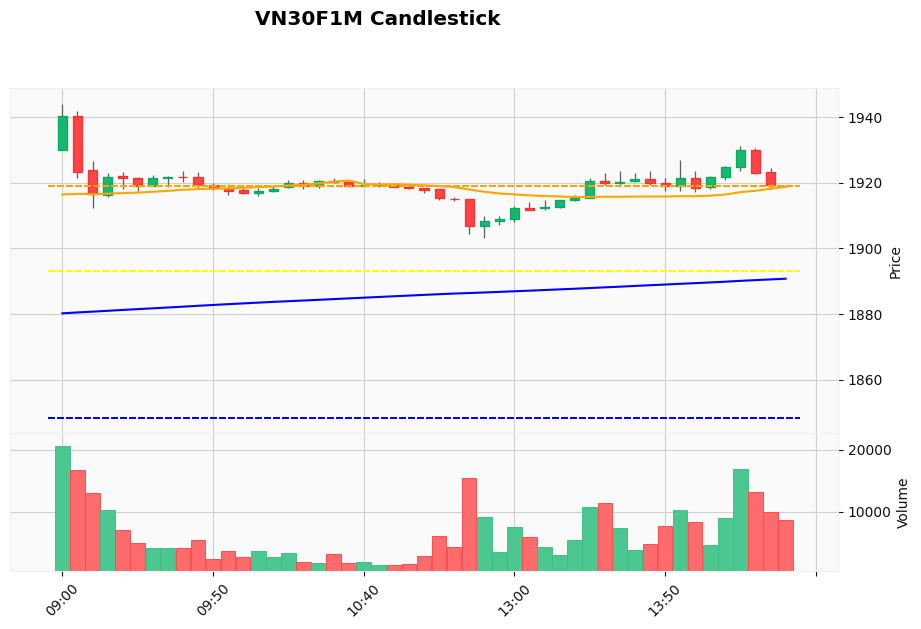

In [41]:
mpf.plot(
    selected_df,
    type='candle',         # kiểu biểu đồ: 'candle', 'ohlc', 'line'
    volume=True,           # hiển thị volume
    style='yahoo',         # theme đẹp ('charles', 'nightclouds', 'yahoo', 'binance', ...)
    title="VN30F1M Candlestick",
    ylabel='Price',
    ylabel_lower='Volume',
    figratio=(10,6),
    figscale=1.2,
    hlines=dict(hlines=[_1st_poc, _2nd_poc, _3rd_poc],
                     colors=['blue', 'yellow', 'orange'],
                     linestyle='--', linewidths=1.2),
    addplot=[ma20_line, ma250_line],
)